In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import boxcox
pd.options.display.max_rows = 100
## Install xlrd package to load Excel files
#!conda install openpyxl
#!conda install xlrd
from sklearn.preprocessing import PowerTransformer, StandardScaler, minmax_scale
from sklearn.preprocessing import MinMaxScaler

In [24]:
dmca_df = pd.read_csv("Data/Data_Marketing_Customer_Analysis_Round3.csv")
dmca_df

# dataframe divided in numerical and categorical variables
numerical_df = dmca_df.select_dtypes(include=np.number)
categorical_df = dmca_df.select_dtypes(include="object")


# check if there are highly correlated features and drop them if there are any.

In [25]:
# absolute value of correlation between the features.
corr_matrix = numerical_df.corr().abs()
corr_matrix

# selecting values on the "upper triangle" of the correlation matrix, the values above the diagonal ones
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
print(upper_tri)

# dropping values with a value of correlation higher than 0.95
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(); print(to_drop)

                               customer_lifetime_value    income  \
customer_lifetime_value                            NaN  0.003732   
income                                             NaN       NaN   
monthly_premium_auto                               NaN       NaN   
months_since_last_claim                            NaN       NaN   
months_since_policy_inception                      NaN       NaN   
number_of_open_complaints                          NaN       NaN   
number_of_policies                                 NaN       NaN   
total_claim_amount                                 NaN       NaN   

                               monthly_premium_auto  months_since_last_claim  \
customer_lifetime_value                    0.404235                 0.011912   
income                                     0.002431                 0.026564   
monthly_premium_auto                            NaN                 0.010036   
months_since_last_claim                         NaN                

/var/folders/b5/6jnrgrdn769_zhfz2sdxb88c0000gn/T/ipykernel_2826/3970888207.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))


In [31]:
# Converting a categorical column from object to category
categorical_df['coverage'] = categorical_df['coverage'].astype('category')
categorical_df['coverage']

# Assigning numerical values and storing in another column
categorical_df['coverage_label'] = categorical_df['coverage'].cat.codes
categorical_df

,region,response,coverage,education,effective_to_date,month,employment_status,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,coverage_label
0,central,no,basic,college,2/18/11,feb,employed,m,suburban,married,corporate auto,corporate l3,offer3,agent,four-door car,medsize,0
1,west region,no,basic,college,1/18/11,jan,unemployed,f,suburban,single,personal auto,personal l3,offer4,call center,four-door car,medsize,0
2,east,no,basic,bachelor,2/10/11,feb,employed,m,suburban,single,personal auto,personal l3,offer3,call center,suv,medsize,0
3,north west,yes,extended,college,1/11/11,jan,employed,m,suburban,single,corporate auto,corporate l3,offer2,branch,four-door car,medsize,1
4,north west,no,premium,bachelor,1/17/11,jan,medical leave,f,suburban,married,personal auto,personal l2,offer1,branch,four-door car,medsize,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,no,premium,bachelor,1/19/11,jan,unemployed,f,suburban,married,personal auto,personal l1,offer3,web,luxury car,medsize,2
10685,north west,no,basic,college,1/6/11,jan,employed,f,urban,married,personal auto,personal l3,offer2,branch,four-door car,medsize,0
10686,central,no,extended,bachelor,2/6/11,feb,employed,f,rural,married,corporate auto,corporate l3,offer1,web,luxury suv,medsize,1
10687,west region,no,premium,college,2/13/11,feb,employed,f,urban,divorced,personal auto,personal l1,offer1,branch,suv,medsize,2


In [36]:
# Create a dictionary that maps each unique region to an integer
education_map = {"high school or below": 0, "college":1, "bachelor": 1,"master":2, "doctor":3}
education_map

# Replace the values in the "education" column with their mapped integers
categorical_df['education_label'] = categorical_df['education'].map(education_map)
categorical_df

,region,response,coverage,education,effective_to_date,month,employment_status,gender,location_code,marital_status,policy_type,policy,renew_offer_type,sales_channel,vehicle_class,vehicle_size,coverage_label,education_label
0,central,no,basic,college,2/18/11,feb,employed,m,suburban,married,corporate auto,corporate l3,offer3,agent,four-door car,medsize,0,1
1,west region,no,basic,college,1/18/11,jan,unemployed,f,suburban,single,personal auto,personal l3,offer4,call center,four-door car,medsize,0,1
2,east,no,basic,bachelor,2/10/11,feb,employed,m,suburban,single,personal auto,personal l3,offer3,call center,suv,medsize,0,1
3,north west,yes,extended,college,1/11/11,jan,employed,m,suburban,single,corporate auto,corporate l3,offer2,branch,four-door car,medsize,1,1
4,north west,no,premium,bachelor,1/17/11,jan,medical leave,f,suburban,married,personal auto,personal l2,offer1,branch,four-door car,medsize,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,no,premium,bachelor,1/19/11,jan,unemployed,f,suburban,married,personal auto,personal l1,offer3,web,luxury car,medsize,2,1
10685,north west,no,basic,college,1/6/11,jan,employed,f,urban,married,personal auto,personal l3,offer2,branch,four-door car,medsize,0,1
10686,central,no,extended,bachelor,2/6/11,feb,employed,f,rural,married,corporate auto,corporate l3,offer1,web,luxury suv,medsize,1,1
10687,west region,no,premium,college,2/13/11,feb,employed,f,urban,divorced,personal auto,personal l1,offer1,branch,suv,medsize,2,1


# One Hot/Label Encoding of the categorical variables in the categoricals data frame that you created in Activity 3. ( Hint: check Dropfirst option).

In [ ]:
# Create a dictionary that maps each unique region to an integer
# and eplace the values in each column with their mapped integers

categorical_df['region'].unique()
region_map = {"central": 0, "west region":1, "east": 2, "north west":3}
categorical_df['region_label'] = categorical_df['region'].map(region_map)
categorical_df


In [ ]:
categorical_df['employment_status'].unique()
employment_status_map = {"unemployed": 0, "retired": 1, "medical leave": 2, "disabled":3, 'employed':4}
categorical_df['employment_status_label'] = categorical_df['employment_status'].map(employment_status_map)
categorical_df

In [ ]:
categorical_df['marital_status'].unique()
marital_map = {"single": 0, "married":1, "divorced":2}
categorical_df['marital_status_label'] = categorical_df['marital_status'].map(marital_map)
categorical_df

In [ ]:
categorical_df['location_code'].unique()
location_map = {"rural": 0, "suburban":1, "urban":2}
categorical_df['location_code_label'] = categorical_df['location_code'].map(location_map)
categorical_df


In [ ]:
categorical_df['sales_channel'].unique()
sales_map = {"agent": 0, "call center":1, "branch":2, "web":3}
categorical_df['sales_channel_label'] = categorical_df['sales_channel'].map(sales_map)
categorical_df

In [ ]:
categorical_df['vehicle_class'] = categorical_df['vehicle_class'].astype('category')
categorical_df['vehicle_class_label'] = categorical_df['vehicle_class'].cat.codes
print(categorical_df['vehicle_class_label'].unique())
print(categorical_df['vehicle_class'].unique())

In [ ]:
categorical_df['vehicle_size'].unique()
vs_map = {"medsize": 1, "small": 0, "large":2}
categorical_df['vehicle_size_label'] = categorical_df['vehicle_size'].map(vs_map)
categorical_df

In [117]:
categorical_df['policy'] = categorical_df['policy'].astype('category')
categorical_df['policy_label'] = categorical_df['policy'].cat.codes

categorical_df

,region,response,coverage,education,effective_to_date,month,employment_status,gender,location_code,marital_status,...,coverage_label,education_label,region_label,employment_status_label,marital_status_label,location_code_label,sales_channel_label,vehicle_class_label,vehicle_size_label,policy_label
0,central,no,basic,college,2/18/11,feb,employed,m,suburban,married,...,0,1,0,4,1,1,0,0,1,2
1,west region,no,basic,college,1/18/11,jan,unemployed,f,suburban,single,...,0,1,1,0,0,1,1,0,1,5
2,east,no,basic,bachelor,2/10/11,feb,employed,m,suburban,single,...,0,1,2,4,0,1,1,4,1,5
3,north west,yes,extended,college,1/11/11,jan,employed,m,suburban,single,...,1,1,3,4,0,1,2,0,1,2
4,north west,no,premium,bachelor,1/17/11,jan,medical leave,f,suburban,married,...,2,1,3,2,1,1,2,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10684,central,no,premium,bachelor,1/19/11,jan,unemployed,f,suburban,married,...,2,1,0,0,1,1,3,1,1,3
10685,north west,no,basic,college,1/6/11,jan,employed,f,urban,married,...,0,1,3,4,1,2,2,0,1,5
10686,central,no,extended,bachelor,2/6/11,feb,employed,f,rural,married,...,1,1,0,4,1,0,3,2,1,2
10687,west region,no,premium,college,2/13/11,feb,employed,f,urban,divorced,...,2,1,1,4,2,2,2,4,1,3


# varA
- Use minmax transform to bring varA's values into the range [0,1].
- Check that varA has been rescaled using a distplot or a histagram
# varB
- Use StandardScalar or PowerTransform to reduce the skew and standardize varB's distribution.
- Check that the result has zero mean, unit variance, and reduced skew using mean(), std(), and a plot of the PDF.


<AxesSubplot:ylabel='Count'>

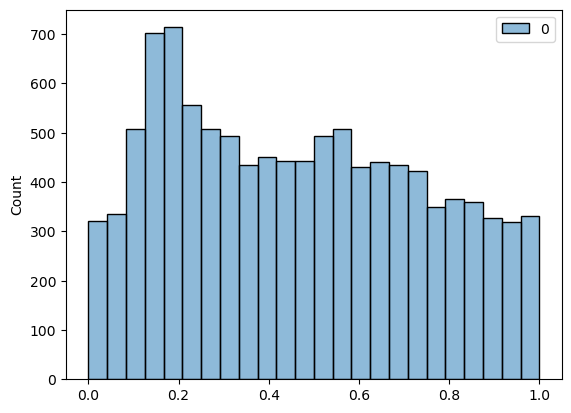

In [94]:
# Use minmax transform to bring varA's values into the range [0,1].
# Check that varA has been rescaled using a distplot or a histagram

from numpy import asarray
varA = numerical_df[["income"]]
data = asarray(varA)
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)
scaled

sns.histplot(scaled)


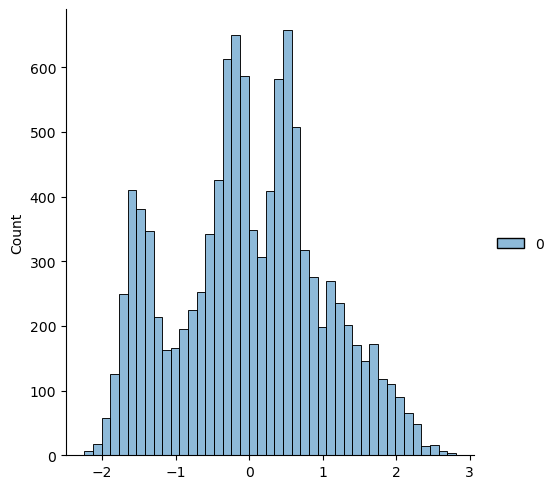

In [106]:
# Power transform using "box-cox" method
from sklearn.preprocessing import power_transform
varB = numerical_df[["customer_lifetime_value"]]
pow_transformed = power_transform(varB, method='box-cox')

sns.displot(pow_transformed)


4.189204154514128e-15
1.0000000000000002


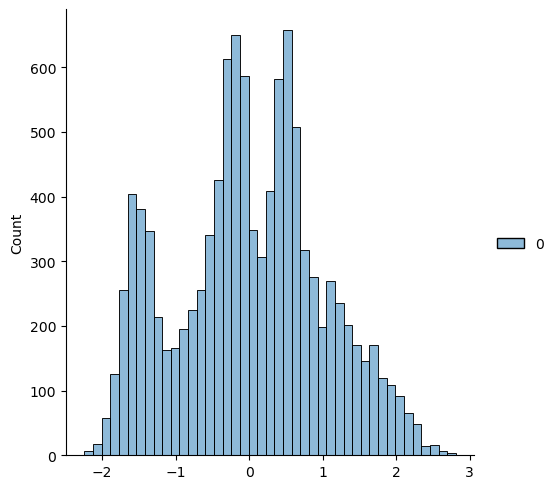

In [115]:
# Power transform using "yeo-johnson" method
from sklearn.preprocessing import power_transform
varB = numerical_df[["customer_lifetime_value"]]
pow_transformed = power_transform(varB, method='yeo-johnson')

sns.displot(pow_transformed)

# chicking mean and st.dev of the new distribution
print(np.mean(pow_transformed))
print(np.std(pow_transformed))